In [1]:
from classes import *

settings = GameSettings(
    market_strength_to_demand = {1:5,2:6,3:9,4:12,5:15,6:18,7:21,8:24},
    player_no_to_market_strength_range = {2:(1,2,4), 3:(2,3,6), 4:(3,4,8)}
)

game = Game(settings, no_players = 2, theme = 'theme_0')

In [ ]:
game.run_turn(render = True, debug = 1)

<h4>Game Overview</h4>
<p>Deck-building game where players are growing a company and product by hiring and renting new employees and buildings into their deck. Each employee and building card has a specific cost associated and contributes to specific attributes of the hypothetical player company and product. Here are the attributes that employees and buildings contribute to:</p>
<li>number of available desks for employees (office building card)</li>
<li>number of units produced (factory building card)</li>
<li>unit cost (engineering employee cards)</li>
<li>brand strength (marketing employee cards)</li>
<li>max number of buildings (operations employee card)</li>
<li>max gross income (finance employee card)</li>

<p>Each turn players will bid against each other to pull new cards from a common pool into their deck and and can remove existing ones to try and optimise their company's net income. Net income will be calculated using a formula based on the above attributes and a product price which players can set arbitrarily.
    
The formula needs to be made as easy as possible, so IRL players can calculate it more or less in their heads using a couple of visual helpers (e.g. cards with sliders to track attributes and indicate the calc).

The main competitive element is that there is a global market demand for the hypothetical product that all players are producing. e.g. how many units can be sold in any one turn by all players combined. This will be dictated by turning cards that move it up or down like a random-walk, simulating economy movement. Each player is essentially trying to grab as big a slice of the global market as possible. The mechanic to enable this is that each player will calculate a 'demand strength' attribute based on their own 'product price' and 'brand strength' attributes. At the end of each turn, the demand strengths will be compared across players and a lookup table or somethinw will determine what proportion of the overall market demand each player is allowed to sell. The idea is that a lower price or better brand can help capture more demand and I'm hoping it leads to kind of price-wars or tactics like selling at a loss in order to elimate other players etc.</p>



<h4>Whats this Notebook</h4>
<p>The main challenge I'm trying to solve here is to make sure the above attributes and price mechanic are balanced and feed meaningfully into the overall 'net income' calc. If they're unbalanced, then some cards might end up being useless to take into the player deck. The attributes each type of card effects are fixed in the function for calculating net income, but the amount they effect the calc is controlled by mapping dictionaries and scaling factors - I'm aiming to come up with the best values for these so that every type of card has a meaningful impact on the net income. </p>
<h4>Game Settings Code</h4>
<p>this is how the parameters are set up and the idea is that I tweak these and then run simulations to try and check how the game progresses or how well balanced it is with different settings</p>

In [2]:
settings, settings1 = [], []
# USE THIS - simple calcs, maxed out at 4 of everything and max price
#V1.5 - emp base cost is 1, factories produce 3 and cost 2, offices support 4 and cost 1
settings.append(GameSettings(base_emp_value = 1, # how much do level 0 employee cards contribute to a single attribute
                             base_emp_cost = 1, # how much do level 0 employee cards cost each turn
                             office_to_desk = 4, # how many desks does each office building have (limits max employees)
                             office_cost = 1, # how much do office cards cost each turn
                             factory_to_prod = 3, # how much do factories produce (limits units that can be sold)
                             factory_cost = 2, # how much do factories cost each turn
                             engineering_to_unit_cost = {0:5,1:4,2:3,3:2,4:1}, # how do engineering points map to 'unit cost' attribute of product
                             marketing_to_brand = {0:1,1:2,2:3,3:4,4:5}, # how do marketing points map to 'brand strength' attribute of product
                             finance_to_max_gross = {0:4,1:12,2:24,3:36,4:48}, # how do finance points map to 'max gross income' attribute of the company (limits how much money company can take in)
                             operations_to_max_buildings = {0:2,1:4,2:6,3:7,4:8}, # how to operations points map to 'max buildings' attribute of company (limits how many buildings can be in player deck)
                             price_to_price_des =  {1:5,2:4,3:3,4:2,5:1},
                             price_des_plus_brand_to_desirability = {2:1,3:1,4:2,5:2,6:3,7:3,8:4,9:4,10:5},
                             market_strength_to_demand = {1:4,2:8,3:12,4:16,5:20,6:24}
                            ))

# V2 - use 0.5 and some other lower cost factories
# Main advantage is that 10% of random combinations give positive net income on a turn, which seems more forgiving
# main disadvantage is that it uses 0.5 as the employee cost, so calcs will start getting a bit trickier for people
#settings1.append(GameSettings(base_emp_value = 1,
#                             base_emp_cost = 0.5,
#                             office_to_desk = 4,
#                             office_cost = 1,
#                             factory_to_prod = 4,
#                             factory_cost = 1,
#                             engineering_to_unit_cost = {0:5,1:4,2:3,3:2,4:1},
#                             marketing_to_brand = {0:2,1:3,2:4,3:5,4:6},
#                             finance_to_max_gross = {0:4,1:8,2:16,3:24,4:32},
#                             operations_to_max_buildings = {0:2,1:3,2:4,3:5,4:6},
#                             price_to_demand = {1:6,2:5,3:4,4:3,5:2} 
#                            ))

# V3 - trying to match V2
# uses integer cost, so easier than 0.5 per employee but only certain combos of ops
# very high percentage of positive net income combinations - so again might be more forgiving
#settings1.append(GameSettings(base_emp_value = 2,
#                             base_emp_cost = 1,
#                             office_to_desk = 2,
#                             office_cost = 1,
#                             factory_to_prod = 4,
#                             factory_cost = 1,
#                             engineering_to_unit_cost = {0:5,2:3,4:1},
#                             marketing_to_brand = {0:2,2:4,4:6},
#                             finance_to_max_gross = {0:4,2:16,4:32},
#                             operations_to_max_buildings = {0:2,2:4,4:6},
#                             price_to_demand = {1:6,2:5,3:4,4:3,5:2} 
#                            ))

In [8]:
# all this is simulating is different hand combinations and calculating the net income from each
# the hand with the highest net income is like the ideal player deck and players might try and reach that deck through different routes
res_dfs, count = [], 0
for setting in settings:
    # set up game and generate sample gamestates
    start_time = time.time()
    game = Game(setting, no_players = 1)
    res = game.players[0].generate_and_analyse_game_states(market_strength = 6, iterations = 1000,  debug = 0)
    res = res.sort_values(by = 'net income', ascending = False) 
    print('---- finished simulation for setting: ' + str(count) + ' time: ' + str((time.time() - start_time)) + ' seconds ----')
    # analyse output
    
    #net_list = res['net income'].tolist()
    #pos_rat = len([x for x in net_list if x > 0])/len(net_list)
    #print('mean: ' + str(np.mean(net_list)) + ', std: ' + str(np.std(net_list)) + ', pos ratio: ' + str(pos_rat))
    #print(res[0:5][['gamestate key','net income']])
    #res_dfs.append(res)
    #count += 1

---- finished simulation for setting: 0 time: 2.960570812225342 seconds ----


In [9]:
res

,market strength,gamestate key,operations,finance,engineering,marketing,offices,factories,price,unit cost (derived),net income
7676,6,"(4, 4, 4, 0, 3, 4, 5)",4,4,4,0,3,4,5,1,25
9113,6,"(3, 4, 4, 1, 3, 4, 5)",3,4,4,1,3,4,5,1,25
9996,6,"(4, 4, 4, 1, 4, 4, 5)",4,4,4,1,4,4,5,1,23
9309,6,"(4, 4, 4, 0, 3, 5, 5)",4,4,4,0,3,5,5,1,23
5613,6,"(4, 4, 3, 0, 3, 5, 5)",4,4,3,0,3,5,5,2,21
...,...,...,...,...,...,...,...,...,...,...,...
5001,6,"(4, 4, 4, 4, 7, 0, 3)",4,4,4,4,7,0,3,1,-23
5295,6,"(4, 4, 4, 4, 8, 0, 3)",4,4,4,4,8,0,3,1,-24
8126,6,"(4, 4, 4, 4, 8, 0, 5)",4,4,4,4,8,0,5,1,-24
8154,6,"(4, 4, 4, 4, 8, 0, 4)",4,4,4,4,8,0,4,1,-24


In [12]:
special_keys = [
    (4, 4, 4, 4, 4, 2, 5), # max employees + 4 offices and 2 warehouses
    (4, 4, 4, 4, 4, 4, 5), # max employees + 4 offices and 4 warehouses
    (4, 4, 4, 4, 4, 4, 4),
    (3, 4, 4, 1, 3, 4, 5),
    (4, 4, 4, 0, 3, 4, 5)
]
if 1 == 1:
    for i in range(len(settings)):
        print('--- special keys for setting: ' + str(i))
        setting = settings[i]
        game = Game(setting, no_players = 1)
        for key in special_keys:
            print('key: ' + str(key))
            game.companies[0].analyse_game_state(key, market_strength = 3, debug=1)
            print()

--- special keys for setting: 0
key: (4, 4, 4, 4, 4, 2, 5)
A. employees: 16/16, operations: 4, engineering: 4, finance: 4, marketing: 4
B. buildings: 6/8, production: 6, desks: 16
C. (price desirability: 5 + brand desirability: 5) -> desirability: 3
D. market strength: 3 -> total desirability: 3 -> desirability: 3 -> demand: 12/6
E. (price: 5 - unit cost: 1) = unit profit: 4 x units sold: 6 = potential gross: 24/48
F. (actual gross: 24 - total cost: 24) = net income: 0

key: (4, 4, 4, 4, 4, 4, 5)
A. employees: 16/16, operations: 4, engineering: 4, finance: 4, marketing: 4
B. buildings: 8/8, production: 12, desks: 16
C. (price desirability: 5 + brand desirability: 5) -> desirability: 3
D. market strength: 3 -> total desirability: 3 -> desirability: 3 -> demand: 12/12
E. (price: 5 - unit cost: 1) = unit profit: 4 x units sold: 12 = potential gross: 48/48
F. (actual gross: 48 - total cost: 28) = net income: 20

key: (4, 4, 4, 4, 4, 4, 4)
A. employees: 16/16, operations: 4, engineering: 4,

(array([0.00526531, 0.0424898 , 0.08063265, 0.05291837, 0.01459184,
        0.00522449, 0.00177551, 0.00087755, 0.00020408, 0.00010204]),
 array([-24. , -19.1, -14.2,  -9.3,  -4.4,   0.5,   5.4,  10.3,  15.2,
         20.1,  25. ]),
 <BarContainer object of 10 artists>)

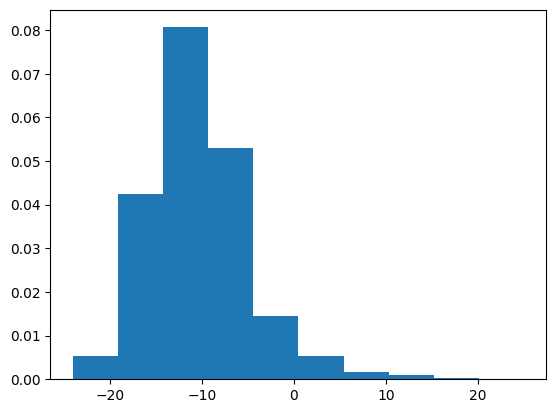

In [13]:
res_arr = res['net income'].to_numpy()
plt.hist(res_arr, density=True)